# **Final Project (Classification of Skin Cancer Images)**

In [1]:
import sys
print(sys.executable)

/Users/mehreenaiman/Documents/GitHub/Skin-Cancer-AI/venv/bin/python


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from clr_callback import CyclicLR




## Load the data from the Csv file

Describe the Data and expand on their short-form names for clarity

In [3]:
# Load the metadata of the 10,000 skin images (Data about the image data)
df = pd.read_csv('./HAM10000_metadata.csv', encoding='utf-8')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lbp_0,lbp_1,lbp_2,...,HOG_1754,HOG_1755,HOG_1756,HOG_1757,HOG_1758,HOG_1759,HOG_1760,HOG_1761,HOG_1762,HOG_1763
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.041511,0.062126,0.056652,...,0.252975,0.147847,0.115414,0.025929,0.074262,0.152823,0.112859,0.252975,0.120974,0.144702
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.038307,0.057678,0.058193,...,0.158993,0.316978,0.334883,0.334883,0.122856,0.051521,0.008979,0.008045,0.002122,0.062720
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.033274,0.054156,0.054459,...,0.070232,0.188405,0.257252,0.257252,0.253869,0.189289,0.033173,0.043144,0.029650,0.062688
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.042556,0.061863,0.060848,...,0.057527,0.227830,0.283290,0.283290,0.039771,0.038306,0.020678,0.016322,0.033532,0.054824
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.019900,0.041715,0.034511,...,0.162982,0.251659,0.332628,0.332628,0.070170,0.249295,0.047084,0.017348,0.002901,0.010409


**Short-form Notation**

**dx**

akeic = Actinic keratoses and intraepithelial carcinoma / Bowen's disease

bcc = basal cell carcinoma

solar lentigines / seborrheic keratoses and lichen-planus like keratoses, 

bkl = benign keratosis-like lesions

df = dermatofibroma

mel = melanoma

nv = melanocytic nevi

angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, 

vasc = melanocytic nevi (nv) and vascular lesions

**dx_type**

histo = histopathology

follow_up = follow-up examination

consensus = expert consensus

confocal = in-vivo confocal microscopy


# **1 - Data Pre-Processing**

In [4]:
# Remove NULL values from the dataset
df.isnull().sum()

lesion_id     0
image_id      0
dx            0
dx_type       0
age          57
             ..
HOG_1759      0
HOG_1760      0
HOG_1761      0
HOG_1762      0
HOG_1763      0
Length: 1781, dtype: int64

Since their is 57 NULL values in the age column, remove those values from the data

In [5]:
df = df.dropna(subset=['age'])

# Check if the NULL values have been successfully removed
df.isnull().sum()

lesion_id    0
image_id     0
dx           0
dx_type      0
age          0
            ..
HOG_1759     0
HOG_1760     0
HOG_1761     0
HOG_1762     0
HOG_1763     0
Length: 1781, dtype: int64

Add the corresponding image path to the metadata csv file

In [6]:
# Merge skin cancer images for the correct path to view
imagePath = './HAM10000_images'

# Pull out the ids from the 'image_id' column
df['full_image_path'] = imagePath + '/' + df['image_id'] + '.jpg'

# Check if the correct image path got added to the dataframe
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lbp_0,lbp_1,lbp_2,...,HOG_1755,HOG_1756,HOG_1757,HOG_1758,HOG_1759,HOG_1760,HOG_1761,HOG_1762,HOG_1763,full_image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.041511,0.062126,0.056652,...,0.147847,0.115414,0.025929,0.074262,0.152823,0.112859,0.252975,0.120974,0.144702,./HAM10000_images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.038307,0.057678,0.058193,...,0.316978,0.334883,0.334883,0.122856,0.051521,0.008979,0.008045,0.002122,0.062720,./HAM10000_images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.033274,0.054156,0.054459,...,0.188405,0.257252,0.257252,0.253869,0.189289,0.033173,0.043144,0.029650,0.062688,./HAM10000_images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.042556,0.061863,0.060848,...,0.227830,0.283290,0.283290,0.039771,0.038306,0.020678,0.016322,0.033532,0.054824,./HAM10000_images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.019900,0.041715,0.034511,...,0.251659,0.332628,0.332628,0.070170,0.249295,0.047084,0.017348,0.002901,0.010409,./HAM10000_images/ISIC_0031633.jpg


Transform the 'dx' and 'dx_type' columns into equivalent numerical values

In [7]:
# Change dx to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['dx_numerical'] = df['dx'].astype('category').cat.codes

# Change dx_type to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['dx_type_numerical'] = df['dx_type'].astype('category').cat.codes

# Change gender to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['sex_numerical'] = df['sex'].astype('category').cat.codes

# Change localization to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['localization_numerical'] = df['localization'].astype('category').cat.codes

# Check in data
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lbp_0,lbp_1,lbp_2,...,HOG_1759,HOG_1760,HOG_1761,HOG_1762,HOG_1763,full_image_path,dx_numerical,dx_type_numerical,sex_numerical,localization_numerical
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.041511,0.062126,0.056652,...,0.152823,0.112859,0.252975,0.120974,0.144702,./HAM10000_images/ISIC_0027419.jpg,2,3,1,11
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.038307,0.057678,0.058193,...,0.051521,0.008979,0.008045,0.002122,0.062720,./HAM10000_images/ISIC_0025030.jpg,2,3,1,11
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.033274,0.054156,0.054459,...,0.189289,0.033173,0.043144,0.029650,0.062688,./HAM10000_images/ISIC_0026769.jpg,2,3,1,11
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.042556,0.061863,0.060848,...,0.038306,0.020678,0.016322,0.033532,0.054824,./HAM10000_images/ISIC_0025661.jpg,2,3,1,11
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.019900,0.041715,0.034511,...,0.249295,0.047084,0.017348,0.002901,0.010409,./HAM10000_images/ISIC_0031633.jpg,2,3,1,4


# **2 - Image Pre-processing**

In [8]:
# Load the images into the notebook
# img = cv2.imread('image1.png', cv2.IMREAD_GRAYSCALE)

# Create a new column for the images (125:w by 100:h)
df['skin_image'] = df['full_image_path'].map(lambda x: np.asarray(Image.open(x).resize((125, 100))))

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lbp_0,lbp_1,lbp_2,...,HOG_1760,HOG_1761,HOG_1762,HOG_1763,full_image_path,dx_numerical,dx_type_numerical,sex_numerical,localization_numerical,skin_image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.041511,0.062126,0.056652,...,0.112859,0.252975,0.120974,0.144702,./HAM10000_images/ISIC_0027419.jpg,2,3,1,11,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.038307,0.057678,0.058193,...,0.008979,0.008045,0.002122,0.062720,./HAM10000_images/ISIC_0025030.jpg,2,3,1,11,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.033274,0.054156,0.054459,...,0.033173,0.043144,0.029650,0.062688,./HAM10000_images/ISIC_0026769.jpg,2,3,1,11,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.042556,0.061863,0.060848,...,0.020678,0.016322,0.033532,0.054824,./HAM10000_images/ISIC_0025661.jpg,2,3,1,11,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.019900,0.041715,0.034511,...,0.047084,0.017348,0.002901,0.010409,./HAM10000_images/ISIC_0031633.jpg,2,3,1,4,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [9]:
print(df.columns)  # Show available columns
print(df.head())  # Display first few rows

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'lbp_0', 'lbp_1', 'lbp_2',
       ...
       'HOG_1760', 'HOG_1761', 'HOG_1762', 'HOG_1763', 'full_image_path',
       'dx_numerical', 'dx_type_numerical', 'sex_numerical',
       'localization_numerical', 'skin_image'],
      dtype='object', length=1787)
     lesion_id      image_id   dx dx_type   age   sex localization     lbp_0  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  0.041511   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  0.038307   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  0.033274   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  0.042556   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  0.019900   

      lbp_1     lbp_2  ...  HOG_1760  HOG_1761  HOG_1762  HOG_1763  \
0  0.062126  0.056652  ...  0.112859  0.252975  0.120974  0.144702   
1  0.057678  0.058193  ...  0.008979 

In [10]:
print(df['skin_image'])

0        [[[189, 152, 194], [192, 156, 198], [191, 154,...
1        [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...
2        [[[186, 127, 135], [189, 133, 145], [192, 135,...
3        [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...
4        [[[131, 88, 110], [142, 97, 120], [152, 107, 1...
                               ...                        
10010    [[[143, 125, 134], [140, 122, 131], [140, 122,...
10011    [[[5, 6, 3], [6, 7, 4], [7, 8, 5], [8, 8, 6], ...
10012    [[[109, 99, 102], [122, 111, 112], [132, 121, ...
10013    [[[157, 121, 143], [160, 125, 145], [155, 114,...
10014    [[[179, 147, 132], [177, 146, 137], [177, 141,...
Name: skin_image, Length: 9958, dtype: object


# **Load LBP Features**

In [11]:
# Load existing metadata file with LBP
# df = pd.read_csv('./HAM10000_metadata.csv')

# Drop rows with missing age again if needed
df = df.dropna(subset=['age'])

# Load LBP columns
lbp_columns = [col for col in df.columns if col.startswith('lbp_')]
X_lbp = df[lbp_columns].values


More Image Pre-processing

__Feature Extraction Technique__

SIFT - To extract key points and descriptors for object recognition

In [12]:
# Detect the keypoints and create the descriptor
# sift = cv2.xfeatures2d.SIFT_create()

**Adding a Histogram of Oriented Gradients**

In [13]:

# Load HOG columns
hog_columns = [col for col in df.columns if col.startswith('HOG_')]
X_hog = df[hog_columns].values


# **3 - Data Visualization w/h Graphs**

Text(0, 0.5, 'Count')

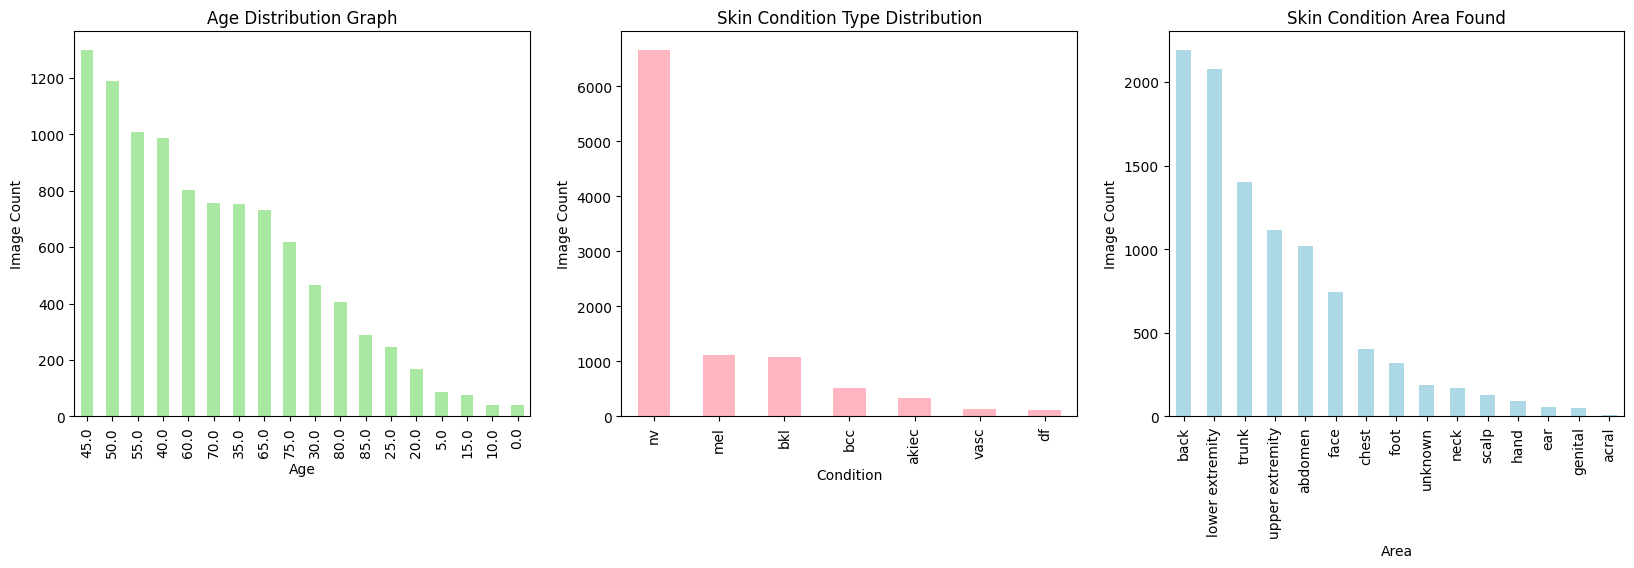

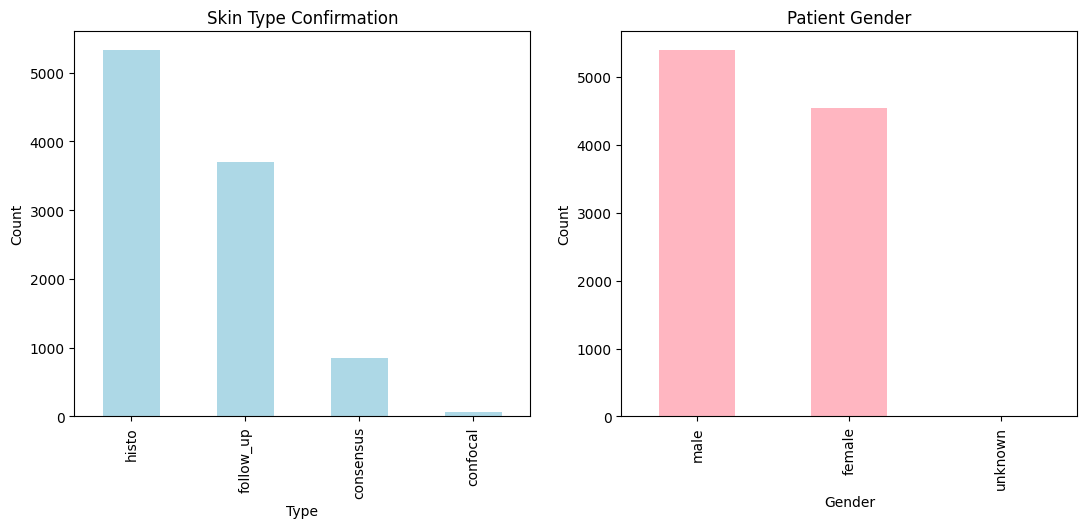

In [14]:
plt.figure(figsize=(20, 5))

# Plot the ages
plt.subplot(1, 3, 1)
plt.title("Age Distribution Graph")
df['age'].value_counts().plot.bar(color='#A8E8A3')
plt.xlabel("Age")
plt.ylabel("Image Count")

# Plot the Skin Condition Type
plt.subplot(1, 3, 2)
plt.title("Skin Condition Type Distribution")
df['dx'].value_counts().plot.bar(color='lightpink')
plt.xlabel("Condition")
plt.ylabel("Image Count")

# Plot the Area Skin Condition was found
plt.subplot(1, 3, 3)
plt.title("Skin Condition Area Found")
df['localization'].value_counts().plot.bar(color='lightblue')
plt.xlabel("Area")
plt.ylabel("Image Count")

plt.figure(figsize=(20, 5))

# Plot the type of confirmation of the skin type from health-care professionals
plt.subplot(1, 3, 1)
plt.title("Skin Type Confirmation")
df['dx_type'].value_counts().plot.bar(color='lightblue')
plt.xlabel("Type")
plt.ylabel("Count")

# Plot the gender distribution of the data
plt.subplot(1, 3, 2)
plt.title("Patient Gender")
df['sex'].value_counts().plot.bar(color='lightpink')
plt.xlabel("Gender")
plt.ylabel("Count")


# **4 - CNN ML Model**

In [15]:
# Import the necessary libraries
# from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
# from keras.optimizers import Adam
# from keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Splitting the Data
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Implement the CNN Keras libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical


In [16]:
print(df.columns)  # Show available columns
print(df.head())  # Display first few rows


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'lbp_0', 'lbp_1', 'lbp_2',
       ...
       'HOG_1760', 'HOG_1761', 'HOG_1762', 'HOG_1763', 'full_image_path',
       'dx_numerical', 'dx_type_numerical', 'sex_numerical',
       'localization_numerical', 'skin_image'],
      dtype='object', length=1787)
     lesion_id      image_id   dx dx_type   age   sex localization     lbp_0  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  0.041511   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  0.038307   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  0.033274   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  0.042556   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  0.019900   

      lbp_1     lbp_2  ...  HOG_1760  HOG_1761  HOG_1762  HOG_1763  \
0  0.062126  0.056652  ...  0.112859  0.252975  0.120974  0.144702   
1  0.057678  0.058193  ...  0.008979 

Train, Test, Split the Data

- Test size: 20%
- Training size: 80%

In [17]:
# Trying different way to retrieve image pixel values

# Split the excel file into training data for X and Y
Y = df['dx_numerical']
X_image = df.drop(labels = ['dx_numerical'], axis = 1)

# Seperate the other features (other then image pixel values)
X_other = df[['dx_type_numerical', 'sex_numerical', 'localization_numerical']]

# Split the data
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

X_image_train, X_image_test, X_other_train, X_other_test, X_lbp_train, X_lbp_test, X_hog_train, X_hog_test, Y_train, Y_test = train_test_split(
    X_image, X_other, X_lbp, X_hog, Y, test_size=0.2, random_state=2
)

# Reshape the training data and test X data
X_train = np.asarray(X_image_train['skin_image'].tolist())
X_test = np.asarray(X_image_test['skin_image'].tolist())

# Normalize the images


print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)

# Reshape the image into 3 dimensions
X_train = X_train.reshape(X_train.shape[0], *(100, 125, 3))
X_test = X_test.reshape(X_test.shape[0], *(100, 125, 3))

# Process the other features
X_other_train = X_other_train.values
X_other_test = X_other_test.values

# Transform train and testing of Y to categorical
Y_train = to_categorical(Y_train, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

print("x_train Reshaped",X_train.shape)
print("x_test Reshaped",X_test.shape)
print("y_train Reshaped",Y_train.shape)
print("y_test Reshaped",Y_test.shape)


x_train shape (7966, 100, 125, 3)
x_test shape (1992, 100, 125, 3)
y_train shape (7966,)
y_test shape (1992,)
x_train Reshaped (7966, 100, 125, 3)
x_test Reshaped (1992, 100, 125, 3)
y_train Reshaped (7966, 7)
y_test Reshaped (1992, 7)


**Data Augmentation**

Testing the Commented Out Below

In [18]:
# # Perform data augmentation to prevent overfitting
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

# datagen.fit(X_train)

# Initialize the ImageDataGenerator for image augmentation
# # This code was NOT giving good results --> 68% training accuracy
# image_datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Currently not giving good results
# image_datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

# # Fit the image data generator on the training image data
# image_datagen.fit(X_train)

Create the CNN Model

In [19]:
model = Sequential()

input_shape = (100, 125, 3)
# input_shape = (28,28,3)
num_classes = 7

# Image branch
image_input = Input(shape=input_shape)  # Define image input
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(image_input)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.16)(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)    # Flatten the CNN output

# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
# image_output = Dense(64, activation="relu")(x)  # Intermediate output before merging

# Other features input branch - Numerical Data Input
other_input = Input(shape=(X_other_train.shape[1],))
other_output = Dense(32, activation='relu')(other_input)
other_output = Dense(16, activation='relu')(other_output)



#LBP input branch
lbp_input = Input(shape=(X_lbp_train.shape[1],), name="lbp_input")
l = Dense(64, activation='relu')(lbp_input)
l = Dense(32, activation='relu')(l)

# HOG input branch
hog_input = Input(shape=(X_hog_train.shape[1],), name="hog_input")
h = Dense(64, activation='relu')(hog_input)
h = Dense(32, activation='relu')(h)





# Combine branches of CNN and other features together
merged = concatenate([x, other_output,l])
z = Dense(64, activation='relu')(merged)
z = Dense(32, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation="softmax")(z)

# Create model
model = Model(inputs=[image_input, other_input, lbp_input, hog_input], outputs=output)

Define Optimizer

In [20]:
# Define the optimizer
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# print(model.summary())

# print(model.input_shape)

for i, inp in enumerate(model.inputs):
    print(f"Input {i+1} shape:", inp.shape)

print(model.output_shape)

# Grab only the first 7966 instances for the numerical values from the other categories
X_other = X_other[:7966]  # Trim to match image data


print("Model Input 1 Expected:", model.input_shape[0])
print("Model Input 2 Expected:", model.input_shape[1])
print("Model Output Expected:", model.output_shape)

print("X_train_image Shape:", X_train.shape)
print("X_other Shape:", X_other.shape)
print("Y_train Shape:", Y_train.shape)



# Set the epochs and batch size
epochs = 60
batch_size = 15

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


Input 1 shape: (None, 100, 125, 3)
Input 2 shape: (None, 3)
Input 3 shape: (None, 10)
Input 4 shape: (None, 1764)
(None, 7)
Model Input 1 Expected: (None, 100, 125, 3)
Model Input 2 Expected: (None, 3)
Model Output Expected: (None, 7)
X_train_image Shape: (7966, 100, 125, 3)
X_other Shape: (7966, 3)
Y_train Shape: (7966, 7)


In [21]:
print("X_train_image shape:", X_train.shape)
print("X_other shape:", X_other.shape)
print("Y_train shape:", Y_train.shape)
print("X_test_image shape:", X_test.shape)
print("X_other_test shape:", X_other_test.shape)
print("Y_test shape:", Y_test.shape)



X_train_image shape: (7966, 100, 125, 3)
X_other shape: (7966, 3)
Y_train shape: (7966, 7)
X_test_image shape: (1992, 100, 125, 3)
X_other_test shape: (1992, 3)
Y_test shape: (1992, 7)


**Debugging:** Testing Print Statements

In [22]:
print("X_train:", X_train is None)
print("Y_train:", Y_train is None)
print("X_test:", X_test is None)
print("Y_test:", Y_test is None)
print("Y_train shape:", Y_train.shape)

# Check for NaN or None in X_train and Y_train
print("X_train has NaN values:", np.isnan(X_train).sum() > 0)
print("Y_train has NaN values:", np.isnan(Y_train).sum() > 0)

# Check if there are any None values
print("X_train has None values:", X_train is None)
print("Y_train has None values:", Y_train is None)

# Check if Y_train is empty or has incorrect shape
print("Y_train shape:", Y_train.shape)

print(X_train is None)  # Should print False
print(X_other_train is None)
print(X_test is None)
print(X_other_test is None)
print(Y_test is None)

print("X_train_image: ", X_train.shape)       # Should match the CNN input shape
print("X_other: ", X_other_train.shape) # Should match the numerical input shape
print("Y_test: ", Y_test.shape)        # Should match the output shape


X_train: False
Y_train: False
X_test: False
Y_test: False
Y_train shape: (7966, 7)
X_train has NaN values: False
Y_train has NaN values: False
X_train has None values: False
Y_train has None values: False
Y_train shape: (7966, 7)
False
False
False
False
False
X_train_image:  (7966, 100, 125, 3)
X_other:  (7966, 3)
Y_test:  (1992, 7)


**Fit the CNN Model**

Ignore Below Commented Out - Testing Data Augmentation Model Fit

In [23]:
# def data_generator_with_augmentation(image_data, numerical_data, labels, batch_size=batch_size):
#     image_gen = image_datagen.flow(image_data, batch_size=batch_size, shuffle=True)
#     num_samples = len(image_data)
    
#     while True:
#         for i in range(0, num_samples, batch_size):
#             # Generate the next batch of augmented images
#             augmented_images = next(image_gen)

#             # Debugging the shapes of the data
#             # print(f"augmented_images shape: {augmented_images.shape}")
#             # print(f"numerical_data shape: {numerical_data.shape}")
            
#             # Get the corresponding batch of numerical data and labels
#             batch_numerical_data = numerical_data[i:i+batch_size]
#             batch_labels = labels[i:i+batch_size]
            
#             # Convert batches to tensors
#             augmented_images = tf.convert_to_tensor(augmented_images, dtype=tf.float32)
#             batch_numerical_data = tf.convert_to_tensor(batch_numerical_data, dtype=tf.float32)
#             batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

#             # print(f"augmented_images (tensor) shape: {augmented_images.shape}")
#             # print(f"batch_numerical_data (tensor) shape: {batch_numerical_data.shape}")
#             # print(f"batch_labels (tensor) shape: {batch_labels.shape}")
            
#             # Yield the batch
#             yield (augmented_images, batch_numerical_data), batch_labels

# # Create a tf.data.Dataset from the generator
# def create_tf_dataset(image_data, numerical_data, labels, batch_size=batch_size):
#     dataset = tf.data.Dataset.from_generator(
#         data_generator_with_augmentation,
#         args=[image_data, numerical_data, labels, batch_size],
#         output_signature=(
#             (tf.TensorSpec(shape=(None, 100, 125, 3), dtype=tf.float32),
#              tf.TensorSpec(shape=(None, 3), dtype=tf.float32)),
#             tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
#         )
#     )
#     return dataset

# # Create the dataset
# train_dataset = create_tf_dataset(X_train, X_other_train, Y_train, batch_size=batch_size)
# val_dataset = create_tf_dataset(X_test, X_other_test, Y_test, batch_size=batch_size)

# # Example of training with the multi-input CNN model
# history = model.fit(
#     train_dataset,
#     # validation_data=val_dataset,
#     validation_data=([X_test, X_other_test], Y_test),  # Use tuple of arrays
#     epochs=50,
#     verbose=1,
#     steps_per_epoch=X_train.shape[0] // batch_size,
#     callbacks=[learning_rate_reduction]
# )

# # Example of training with a multi-input CNN model
# history = model.fit(
#     data_generator_with_augmentation(X_train, X_other_train, Y_train, batch_size=batch_size),
#     validation_data=([X_test, X_other_test], Y_test),
#     epochs=10,
#     verbose=1

#     # datagen.flow(X_train, Y_train, batch_size=batch_size),
#     # epochs=epochs,
#     # validation_data=(X_test, Y_test),
#     # verbose=1,
#     # steps_per_epoch=X_train.shape[0] // batch_size,
#     # callbacks=[learning_rate_reduction]
# )

**Actual CNN model to Fit**

In [24]:
# Try the model.fit with NumPy arrays [THIS GIVES 85.5% accuracy!]
history = model.fit(
    [X_train, X_other_train,X_lbp_train, X_hog_train],
    Y_train,
    validation_data=([X_test, X_other_test,X_lbp_test, X_hog_test], Y_test),
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    callbacks=[learning_rate_reduction]
)


print(history.history) #print the history

Epoch 1/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - accuracy: 0.5838 - loss: 2.6824 - val_accuracy: 0.6621 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 2/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 62s 117ms/step - accuracy: 0.6628 - loss: 1.1529 - val_accuracy: 0.6621 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 3/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 62s 117ms/step - accuracy: 0.6742 - loss: 1.0156 - val_accuracy: 0.6621 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 4/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - accuracy: 0.6784 - loss: 0.9470 - val_accuracy: 0.6677 - val_loss: 0.9824 - learning_rate: 0.0010
Epoch 5/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 65s 123ms/step - accuracy: 0.6793 - loss: 0.9375 - val_accuracy: 0.6621 - val_loss: 0.9058 - learning_rate: 0.0010
Epoch 6/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 68s 128ms/step - accuracy: 0.6687 - loss: 0.9324 - val_accuracy: 0.6832 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 7/60
532/532 ━━━━━━━━━━━━━━━━━━━━ 68s 127ms/step - accuracy: 0.6

**Evaluate the multi-classification model performance**

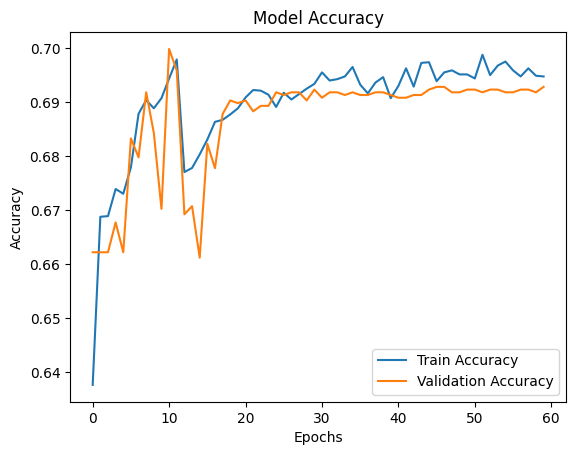

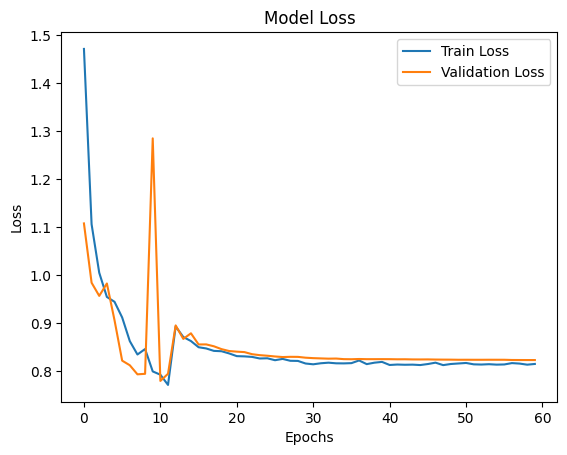

In [25]:
# Plot the training and validation loss/accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [26]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(
    [X_test, X_other_test, X_lbp_test, X_hog_test],  # Multiple inputs
    Y_test
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6918 - loss: 0.8496
Test Accuracy: 0.6928, Test Loss: 0.8227


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


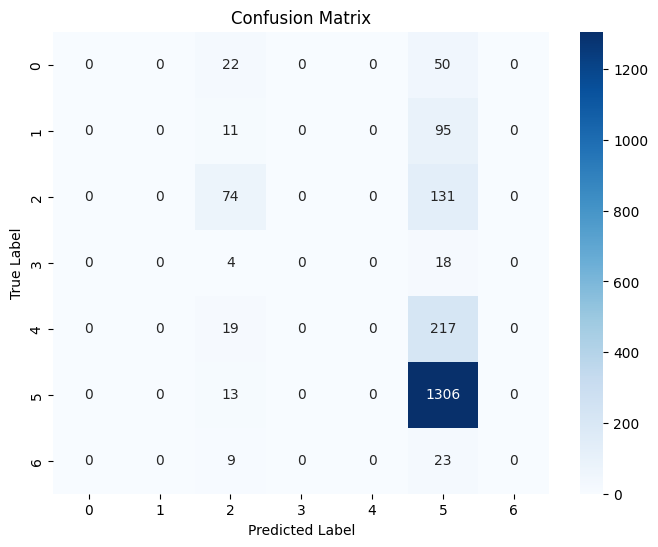

In [27]:
# Compute the Confusion Matrix
# Get model predictions
y_pred = model.predict([X_test, X_other_test, X_lbp_test, X_hog_test])
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()